This is a notebook to explore the trained ANN saved by `create_and_train.py`

In [1]:
try:
    import cPickle as pickle
except:
    import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
# this class needs to be defined to load the pickles
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0 
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
# load the trained network and related objects
with open('ann_objects_updated.pkl', 'rb') as pkl:
    net_objs = pickle.load(pkl)
net = net_objs[0]
x_scaler = net_objs[1]
y_scaler = net_objs[2]

In [4]:
# recreate the training and test sets.  I have tested this and confirmed
# that it always reproduces the same arrays

# specify the seed for random number generation so we can get consistent
# shuffling and initialized weights
np.random.seed(6509)

# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)
y_columns = Y.columns.values
X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)

# Shuffle the dataset (because x parameters are varied in a structured way)
combined = np.concatenate((X, Y), axis=1)
np.random.shuffle(combined)

# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)


0.00463288171844


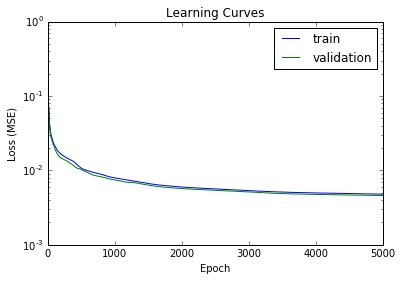

In [5]:
print(net.score(x_train, y_train))

# Plot the learning curves
# helpful in determining whether to continue training or not.
# if both loss functions are still decreasing: more training will pay off.
# If the train loss is much lower than the validation loss, should regularize. 
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('Learning Curves')


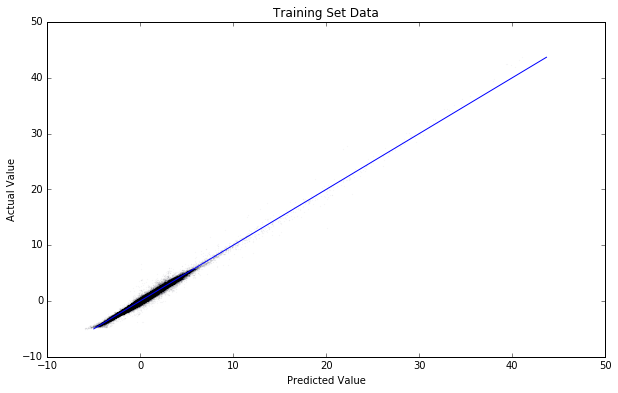

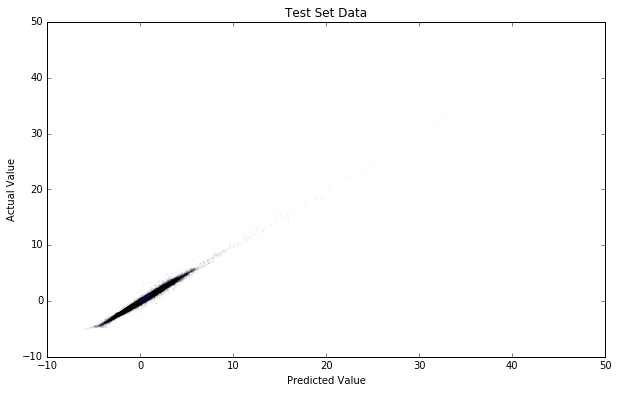

In [6]:
# Parity plot of the training data
plt.figure(2, figsize=(10, 6))
y_predictions = net.predict(x_train)
# upper bound for the number of points to plot
# ub = 2000
ub = y_predictions.shape[0]
plt.scatter(y_predictions[:ub, :].flatten(), y_train[:ub, :].flatten(),
            s=0.1, alpha=0.05)
plt.plot([np.min(y_train),np.max(y_train)],[np.min(y_train),np.max(y_train)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Training Set Data')

# Parity plot of the test data
plt.figure(3, figsize=(10, 6))
y_predictions_test = net.predict(x_test)
plt.scatter(y_predictions_test[:ub, :].flatten(), y_test[:ub, :].flatten(),
           s=0.2, alpha=0.05)
plt.plot([0, 1], [0, 1])
# plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Test Set Data')


In [44]:
pd_y_train = pd.DataFrame(y_train, columns=y_columns)
pd_y_predictions = pd.DataFrame(y_predictions, columns=y_columns)
pd_y_test = pd.DataFrame(y_test, columns=y_columns)
pd_y_predictions_test = pd.DataFrame(y_predictions_test, columns=y_columns)
pd.set_option('display.max_columns', None) 
pd_y_train.describe()

,solids,lighttars,heavytars,totaltars,CO,CO2,othergases,totalgases,H20,H-C-ratio,Moisture,tot_C--O,tot_aromaticC-O,tot_aromaticC-C,tot_aromaticC-H,tot_aliphaticC-O,tot_aromatic_methoxyl,tot_aliphaticC-C,heavy_C--O,heavy_aromatic_C-O,heavy_aromatic_C-C,heavy_aromatic_C-H,heavy_aliphatic_C-O,heavy_aromatic_methoxyl,heavy_aliphatic_C-C,light_C--O,light_aromatic_C-O,light_aromatic_C-H,light_aliphatic_C-O,light_aliphatic_C-C
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.290792,0.520168,0.407722,0.479843,0.653183,0.422021,0.401924,0.588168,0.467763,0.367045,0.244458,0.643942,0.420140,0.237200,0.356472,0.362948,0.461888,0.452143,0.318679,0.630187,0.375621,0.392125,0.117794,0.597111,0.002230,0.665970,0.329530,0.325443,0.283724,0.553502
std,0.123892,0.236475,0.101110,0.103706,0.266629,0.217597,0.159699,0.205352,0.225525,0.145682,0.156365,0.227682,0.224815,0.142601,0.230083,0.171213,0.207311,0.281503,0.119467,0.207458,0.147189,0.234534,0.057529,0.248188,0.022852,0.133468,0.229445,0.228042,0.102644,0.249265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.191467,0.325823,0.339224,0.415611,0.477205,0.269799,0.296189,0.443433,0.285327,0.265850,0.116200,0.511673,0.240839,0.127990,0.170223,0.231465,0.320436,0.175262,0.237073,0.479297,0.273887,0.190653,0.077413,0.411798,0.000113,0.653020,0.130765,0.127838,0.214797,0.337328
50%,0.274070,0.502817,0.395238,0.491039,0.701580,0.364563,0.395532,0.638300,0.449614,0.373832,0.203725,0.675655,0.396146,0.212459,0.314434,0.324645,0.456857,0.449453,0.303046,0.676062,0.368274,0.349169,0.121258,0.649908,0.000172,0.698723,0.275063,0.271652,0.267537,0.617125
75%,0.343479,0.715229,0.460184,0.543209,0.889394,0.548747,0.497257,0.726883,0.646282,0.478861,0.338677,0.827771,0.568106,0.320994,0.516213,0.478726,0.600782,0.690305,0.381189,0.807915,0.466302,0.564487,0.152836,0.814197,0.000276,0.739492,0.494456,0.489598,0.332491,0.771253
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
pd_y_predictions.describe()

,solids,lighttars,heavytars,totaltars,CO,CO2,othergases,totalgases,H20,H-C-ratio,Moisture,tot_C--O,tot_aromaticC-O,tot_aromaticC-C,tot_aromaticC-H,tot_aliphaticC-O,tot_aromatic_methoxyl,tot_aliphaticC-C,heavy_C--O,heavy_aromatic_C-O,heavy_aromatic_C-C,heavy_aromatic_C-H,heavy_aliphatic_C-O,heavy_aromatic_methoxyl,heavy_aliphatic_C-C,light_C--O,light_aromatic_C-O,light_aromatic_C-H,light_aliphatic_C-O,light_aliphatic_C-C
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.290527,0.519645,0.407752,0.479671,0.654130,0.422244,0.401710,0.588760,0.468278,0.367404,0.245128,0.643586,0.419805,0.238751,0.355809,0.363078,0.462170,0.452153,0.319871,0.630095,0.377430,0.391143,0.118463,0.597342,0.002240,0.665296,0.328979,0.324987,0.284223,0.553716
std,0.122919,0.236086,0.098388,0.102742,0.265017,0.217404,0.158792,0.204596,0.223835,0.143162,0.154928,0.227365,0.224341,0.139563,0.229274,0.168624,0.206728,0.280896,0.116480,0.206705,0.144498,0.233616,0.055092,0.247381,0.016876,0.131090,0.227867,0.226416,0.097899,0.248344
min,0.137770,-0.179976,-0.037111,-0.092994,-0.079872,-0.029464,0.061008,-0.012353,0.009890,-0.053025,-0.029315,-0.037181,0.014049,-0.001706,-0.049856,-0.027880,-0.089380,-0.093199,0.019949,-0.058929,0.039891,-0.039948,-0.018183,-0.089934,-0.040619,0.046958,-0.075090,-0.069271,-0.004522,-0.077220
25%,0.193199,0.323291,0.340830,0.416160,0.474791,0.270056,0.291370,0.441333,0.293591,0.270094,0.117590,0.503025,0.242153,0.129290,0.172064,0.233065,0.321534,0.185476,0.238465,0.478687,0.280930,0.193248,0.079325,0.412710,-0.003285,0.651428,0.136064,0.133190,0.215796,0.335617
50%,0.270918,0.502891,0.395283,0.489268,0.709837,0.364890,0.394511,0.636617,0.447992,0.377180,0.205146,0.679097,0.388431,0.218935,0.314854,0.329674,0.457100,0.448647,0.306115,0.674991,0.374218,0.345653,0.125350,0.649725,-0.000074,0.699512,0.277139,0.273769,0.266903,0.615481
75%,0.344032,0.716514,0.458613,0.546697,0.886524,0.550810,0.500855,0.728258,0.642226,0.478767,0.343502,0.823652,0.569373,0.324948,0.512840,0.478805,0.598619,0.690025,0.382100,0.808212,0.463823,0.563575,0.153004,0.813330,0.003406,0.740257,0.493344,0.489486,0.330099,0.772923
max,1.070211,1.016054,0.884260,0.854604,1.044826,1.018642,1.020459,1.021681,0.976853,0.845926,1.054375,0.998417,1.021214,1.051027,1.037429,0.814749,1.055580,0.986214,1.114882,0.990017,1.215236,1.036063,0.613608,1.000016,0.307389,0.976421,1.041884,1.047224,0.809815,0.977560


Comparing the training set with the predictions shows
- that the mean is well captured
- min values slightly less than zero are predicted
- max values slightly greater than one are predicted
- sometimes the max values predicted are significantly less than 1...

In [46]:
pd_y_test.describe()

,solids,lighttars,heavytars,totaltars,CO,CO2,othergases,totalgases,H20,H-C-ratio,Moisture,tot_C--O,tot_aromaticC-O,tot_aromaticC-C,tot_aromaticC-H,tot_aliphaticC-O,tot_aromatic_methoxyl,tot_aliphaticC-C,heavy_C--O,heavy_aromatic_C-O,heavy_aromatic_C-C,heavy_aromatic_C-H,heavy_aliphatic_C-O,heavy_aromatic_methoxyl,heavy_aliphatic_C-C,light_C--O,light_aromatic_C-O,light_aromatic_C-H,light_aliphatic_C-O,light_aliphatic_C-C
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.290951,0.518946,0.407701,0.479402,0.652653,0.423836,0.401737,0.588492,0.469323,0.367200,0.245463,0.643070,0.421868,0.237352,0.356233,0.362192,0.463193,0.451655,0.318416,0.631455,0.375551,0.391061,0.117966,0.598541,0.002254,0.665725,0.330342,0.326244,0.283456,0.553093
std,0.123936,0.236119,0.101015,0.103924,0.266954,0.217449,0.159243,0.205936,0.224601,0.145737,0.156305,0.228071,0.224366,0.141562,0.230105,0.171156,0.206336,0.281867,0.118887,0.206581,0.146792,0.234131,0.057591,0.247348,0.023046,0.133848,0.230000,0.228590,0.102917,0.249729
min,0.021976,0.008312,-0.010182,-0.007767,-0.000511,-0.000034,0.014476,0.000677,0.002055,0.002672,0.000885,-0.019642,0.002592,0.000198,-0.000126,0.001876,-0.000025,0.000003,0.000497,0.000656,-0.000404,0.005091,0.000121,-0.000039,0.000002,-0.002046,0.004739,0.004218,0.001747,-0.000002
25%,0.191658,0.324649,0.339606,0.414364,0.475592,0.270385,0.295660,0.444146,0.287830,0.266533,0.116734,0.508697,0.245029,0.129464,0.169255,0.231883,0.322406,0.175283,0.237121,0.480215,0.274355,0.189962,0.077606,0.413005,0.000113,0.652879,0.130382,0.127374,0.214736,0.335970
50%,0.274831,0.501104,0.395080,0.489914,0.698960,0.367867,0.396186,0.638359,0.452294,0.373584,0.205471,0.674792,0.399150,0.214123,0.314505,0.322696,0.458368,0.449254,0.303483,0.677830,0.368774,0.347726,0.121562,0.652216,0.000172,0.699026,0.276192,0.272760,0.266168,0.615988
75%,0.343666,0.711696,0.460545,0.542968,0.889154,0.551356,0.497596,0.729066,0.646285,0.478901,0.340161,0.826258,0.569288,0.321128,0.518505,0.475736,0.600995,0.689423,0.380178,0.808619,0.465860,0.564636,0.153166,0.814784,0.000276,0.739735,0.496060,0.491734,0.332019,0.771755
max,1.007272,1.000019,0.945093,0.948296,0.999758,0.998451,0.979087,1.000001,0.998830,0.987383,0.982577,0.999886,0.997161,0.993619,0.998482,0.981024,0.999724,0.999807,0.955109,0.996807,0.995209,0.999700,1.060363,0.997999,1.022002,1.001466,0.998920,0.999488,1.024391,0.982522


In [47]:
pd_y_predictions_test.describe()

,solids,lighttars,heavytars,totaltars,CO,CO2,othergases,totalgases,H20,H-C-ratio,Moisture,tot_C--O,tot_aromaticC-O,tot_aromaticC-C,tot_aromaticC-H,tot_aliphaticC-O,tot_aromatic_methoxyl,tot_aliphaticC-C,heavy_C--O,heavy_aromatic_C-O,heavy_aromatic_C-C,heavy_aromatic_C-H,heavy_aliphatic_C-O,heavy_aromatic_methoxyl,heavy_aliphatic_C-C,light_C--O,light_aromatic_C-O,light_aromatic_C-H,light_aliphatic_C-O,light_aliphatic_C-C
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.290727,0.518309,0.407849,0.479270,0.653374,0.424052,0.401631,0.588975,0.469968,0.367418,0.246047,0.642687,0.421590,0.239168,0.355533,0.362203,0.463602,0.451510,0.319775,0.631323,0.377518,0.390053,0.118524,0.598735,0.002138,0.665179,0.329779,0.325745,0.283921,0.553318
std,0.122755,0.235919,0.098300,0.102953,0.265376,0.217295,0.158412,0.205199,0.222960,0.143202,0.154837,0.227862,0.224082,0.138862,0.229395,0.168413,0.205770,0.281476,0.116178,0.205835,0.144287,0.233261,0.055026,0.246558,0.016796,0.131276,0.228533,0.227053,0.097765,0.248993
min,0.138823,-0.146999,-0.015071,-0.060126,-0.079873,-0.025959,0.061001,-0.002590,0.019661,-0.050749,-0.015024,-0.025446,0.025417,-0.002242,-0.051133,-0.033347,-0.078870,-0.084567,0.023329,-0.025931,0.040971,-0.029851,-0.017142,-0.077686,-0.038506,0.062773,-0.061075,-0.058073,0.005168,-0.063542
25%,0.193295,0.322697,0.341167,0.415036,0.472950,0.270892,0.291211,0.442655,0.296319,0.269965,0.118390,0.500602,0.245936,0.130778,0.170845,0.232797,0.323846,0.185292,0.238431,0.479981,0.281573,0.192552,0.079204,0.413779,-0.003329,0.651754,0.136131,0.133226,0.216071,0.334119
50%,0.272177,0.500632,0.395308,0.488348,0.707043,0.368138,0.395623,0.635788,0.449742,0.376555,0.207952,0.677921,0.392212,0.220578,0.315000,0.328019,0.458638,0.447586,0.306509,0.676644,0.374510,0.344509,0.125468,0.651421,-0.000093,0.699805,0.278444,0.274941,0.265892,0.614394
75%,0.344760,0.713040,0.459199,0.546389,0.886258,0.552984,0.501378,0.729439,0.641741,0.478709,0.344641,0.822456,0.570606,0.324978,0.514851,0.475284,0.600047,0.688926,0.381723,0.808905,0.463554,0.562752,0.153195,0.814358,0.003383,0.740150,0.496056,0.491675,0.329714,0.773528
max,1.047290,1.015304,0.878859,0.845745,1.038230,1.017638,1.021115,1.022507,0.973898,0.831250,1.010106,0.997233,1.018129,0.961548,1.040398,0.815899,1.053817,0.985382,1.061702,0.986492,1.172356,1.027495,0.584894,0.992139,0.291290,0.978669,1.045062,1.053699,0.777043,0.972760


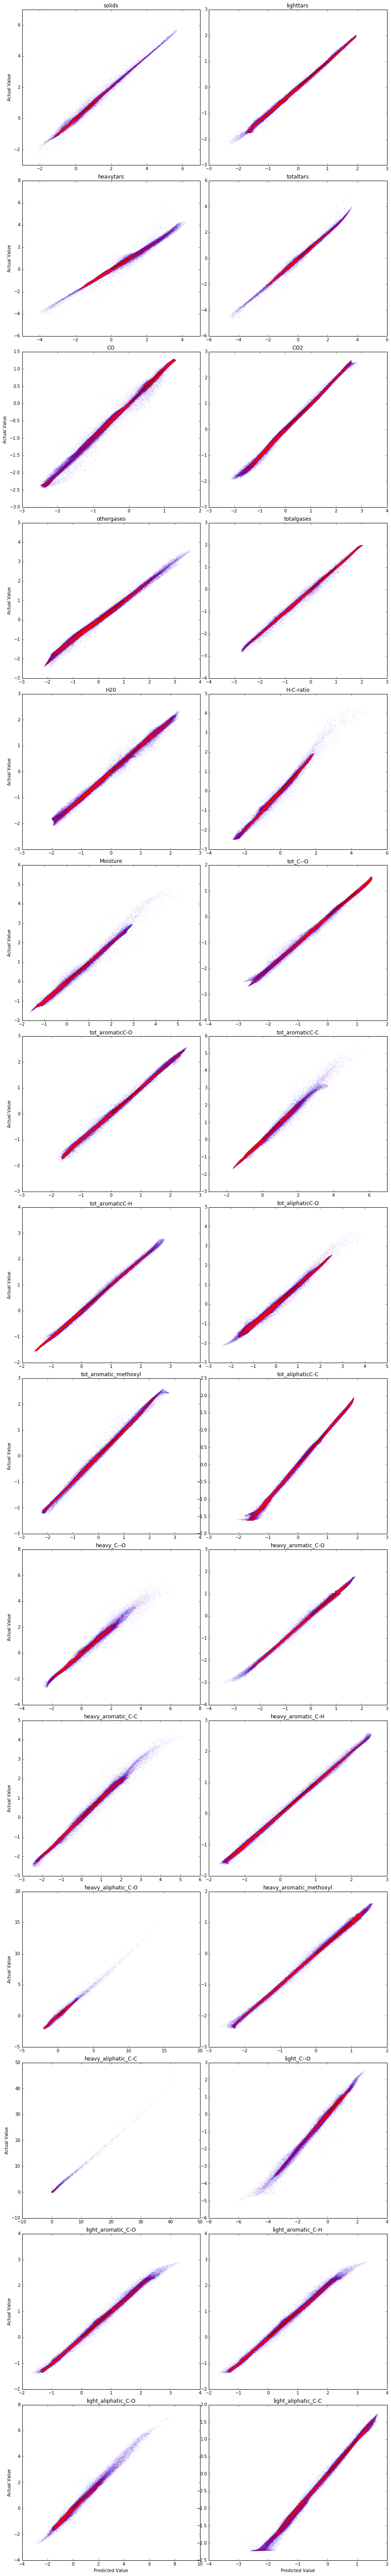

In [9]:
y_predictions = net.predict(x_train)
y_predictions_test = net.predict(x_test)

def pplot_one_output(y_predictions, y_predictions_test, output_col, ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]

    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub, output_col].flatten(),
                           y_train[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='b', marker='x', label='train')
    ax[output_col].plot([0, 1], [0, 1], c='black')
    ax[output_col].scatter(y_predictions_test[:ub, output_col].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('%s' % y_columns[output_col])
#     ax[output_col].set_xlim([-0.1, 1.1]) 
#     ax[output_col].set_ylim([-0.1, 1.1])

    
output_list = y_columns[:]
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()
for i, x in enumerate(output_list):
    pplot_one_output(y_predictions, y_predictions_test, i)
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [10]:
r_squared = {}
for i, x in enumerate(output_list):
    r_squared[x] = r2_score(y_train[:, i], y_predictions[:, i])
r_squared

{'CO': 0.99656056997181552,
 'CO2': 0.99736287370043075,
 'H-C-ratio': 0.9940321483505431,
 'H20': 0.99562445995271842,
 'Moisture': 0.99459685189448543,
 'heavy_C--O': 0.988166295935063,
 'heavy_aliphatic_C-C': 0.99436361205817547,
 'heavy_aliphatic_C-O': 0.99171267239608696,
 'heavy_aromatic_C-C': 0.99390949076022617,
 'heavy_aromatic_C-H': 0.99840824396532502,
 'heavy_aromatic_C-O': 0.99780359412360065,
 'heavy_aromatic_methoxyl': 0.99816258088275744,
 'heavytars': 0.99045718255092285,
 'light_C--O': 0.99220007826155998,
 'light_aliphatic_C-C': 0.99720217368073438,
 'light_aliphatic_C-O': 0.98896768449820305,
 'light_aromatic_C-H': 0.99719337448833356,
 'light_aromatic_C-O': 0.99722009349533802,
 'lighttars': 0.99858363212468526,
 'othergases': 0.99423256234147528,
 'solids': 0.99558047678176098,
 'tot_C--O': 0.99772798660811879,
 'tot_aliphaticC-C': 0.99836099351333718,
 'tot_aliphaticC-O': 0.99323487947488154,
 'tot_aromaticC-C': 0.99325964439020709,
 'tot_aromaticC-H': 0.99838254

In [36]:
# old r_squared values (for the original network)

{'CO': 0.9872102407920309,
 'CO2': 0.99831477413535497,
 'H-C-ratio': 0.9732516480103286,
 'H20': 0.98567867801781484,
 'Moisture': 0.97730880509188678,
 'heavy_C--O': 0.94965443783355818,
 'heavy_aliphatic_C-C': 0.5141602203690655,
 'heavy_aliphatic_C-O': 0.91558716754200464,
 'heavy_aromatic_C-C': 0.96630852705452674,
 'heavy_aromatic_C-H': 0.99470281850191311,
 'heavy_aromatic_C-O': 0.99402432722151524,
 'heavy_aromatic_methoxyl': 0.99520844915151874,
 'heavytars': 0.95001552630398556,
 'light_C--O': 0.96602829227486653,
 'light_aliphatic_C-C': 0.99157157448631117,
 'light_aliphatic_C-O': 0.91578965066153284,
 'light_aromatic_C-H': 0.9871394913172904,
 'light_aromatic_C-O': 0.98785505529812678,
 'lighttars': 0.9948038509603061,
 'othergases': 0.98692273319671409,
 'solids': 0.97849898925493739,
 'tot_C--O': 0.99359257437137716,
 'tot_aliphaticC-C': 0.9957859524363305,
 'tot_aliphaticC-O': 0.97260221137497493,
 'tot_aromaticC-C': 0.96461247283311291,
 'tot_aromaticC-H': 0.99585304850

The loss function being used is "squared_error" (from lasagne.objectives import squared_error)  
score is mean_squared_error (from sklearn.metrics import mean_squared_error)

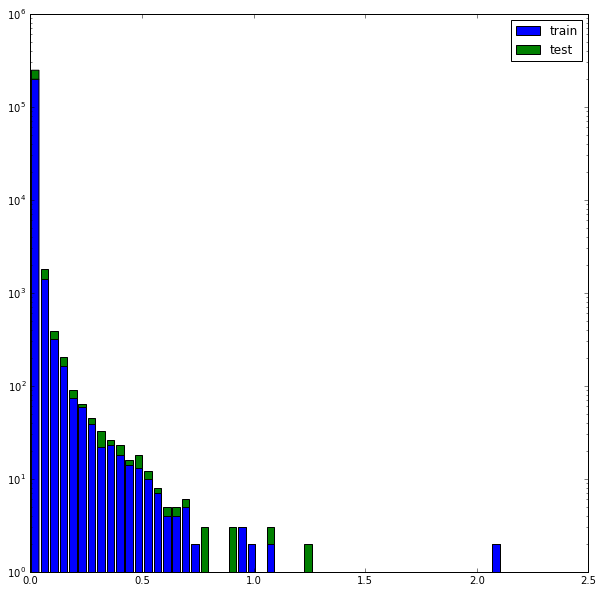

In [11]:
#this calculates the MSE for every value in the set so you can make a histogram
train_mse = []
for i, value in enumerate(y_train[:]):
    train_mse.append(mean_squared_error(y_train[i], y_predictions[i]))
    
test_mse = []
for i, value in enumerate(y_test[:]):
    test_mse.append(mean_squared_error(y_test[i], y_predictions_test[i]))

plt.figure(3, figsize=(10, 10))
plt.hist([train_mse, test_mse], bins=50, stacked=True, label=['train', 'test'],
         log=True)
plt.legend(loc=0)

# Note: can also do this for specific output measures if desired...
# mean_squared_error(y_train, y_predictions, multioutput='raw_values')

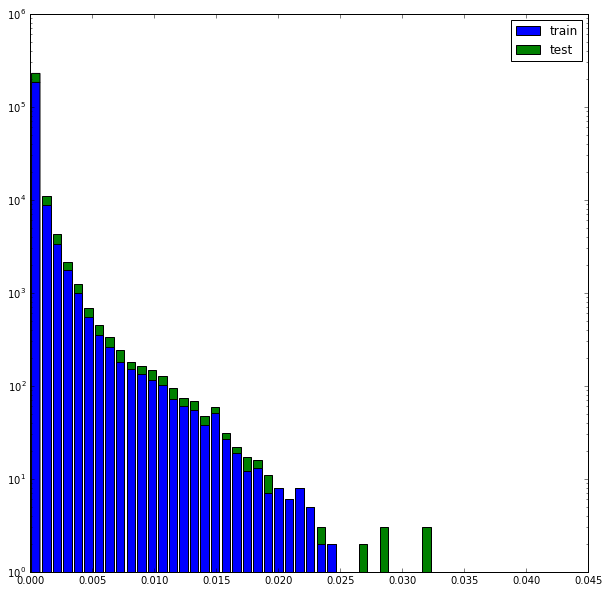

In [26]:
# Make a histogram for a specific output measure
output_col = 0
train_mse = []
for i, value in enumerate(y_train[:]):
    train_mse.append(mean_squared_error([y_train[i][output_col]],
                                        [y_predictions[i][output_col]]))
    
test_mse = []
for i, value in enumerate(y_test[:]):
    test_mse.append(mean_squared_error([y_test[i][output_col]],
                                       [y_predictions_test[i][output_col]]))

plt.figure(3, figsize=(10, 10))
plt.hist([train_mse, test_mse], bins=50, stacked=True, label=['train', 'test'],
         log=True)
plt.legend(loc=0)
plt.title('%s' % y_columns[output_col])


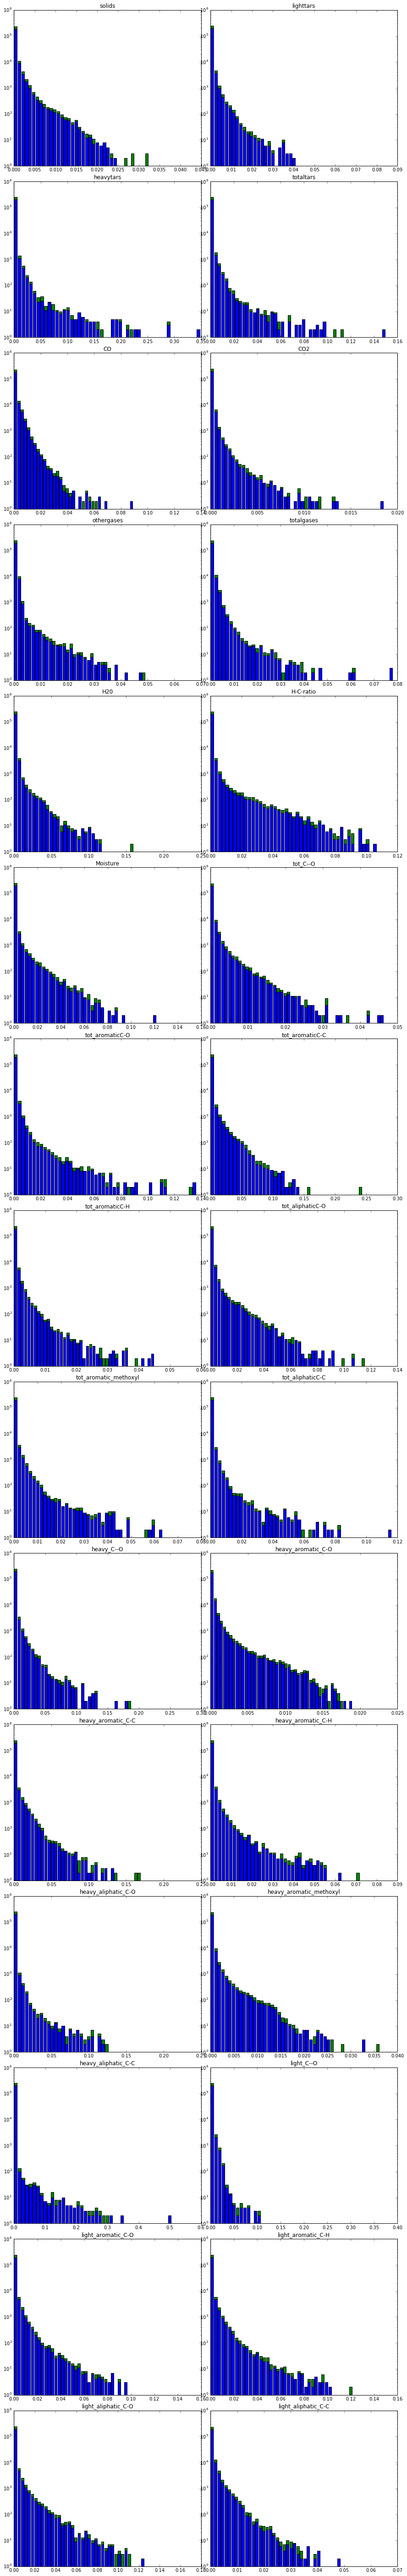

In [33]:
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i][output_col]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i][output_col]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])


output_list = y_columns[:]
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()
for i, x in enumerate(output_list):
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, i)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

# To do

-  figure out what the outliers are
-  we know there is some error, how to describe where the error is and what the impact is on using the model
-  benchmarking - pytest benchmark